In [1]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from src.models.outliers import impute_zero_values
from src.visualization.plots import mutational_spectra_clustermap
from src.config import get_interim_dir, get_experiment_artifacts

In [3]:
results_df = pd.read_pickle(get_experiment_artifacts() + "augmented_with_GO_outlier_results.pkl")
print(results_df.shape)

(18078, 22)


In [6]:
psuedo_controls = pd.read_csv("{}/psuedo_controls.txt".format(get_experiment_artifacts()))["0"].values
print(psuedo_controls[:5])

aliases = results_df.xs("distances", level="Measure", axis=1).columns.to_list()
print(aliases)

X_imputed = pd.read_pickle(get_experiment_artifacts() + "imputed_sample_data.pkl")
print(X_imputed.keys())
print("Data Ready.")

['Gnas' 'Cdc14a' 'Espn' 'Speg' 'Slc4a8']
['T1', 'T2', 'T3']
dict_keys(['T1', 'T2', 'T3'])
Data Ready.


In [7]:
outlier_df = results_df.sort_values(("Global", "Mean Score"), ascending=False).iloc[:500,:]

In [8]:
outliers = outlier_df.sort_values(("Global", "Mean Score"), ascending=False).index

In [11]:
outliers.get_loc("Xrcc6")

8

In [12]:
outliers[:10]

Index(['Atp6v1g1', 'Metap2', 'H2ac18', 'H2ax', 'Xrcc5', 'Qars', 'Mad2l2',
       'Atp2a2', 'Xrcc6', 'Krtap4-8'],
      dtype='object', name='Gene')

In [13]:
"Polq" in outliers

True

In [14]:
Xall = pd.concat(X_imputed, axis=0).dropna()
print("All:", Xall.shape)

Xout = Xall.loc[Xall.index.get_level_values(level=1).isin(outliers[:150])]
Xout.index.set_names("Sample", level=0, inplace=True)
print("Outliers:", Xout.shape)

Xpseudo = Xall.loc[Xall.index.get_level_values(level=1).isin(psuedo_controls)]
print("Psuedo controls:", Xpseudo.shape)

Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=list(X_imputed.keys()), columns=Xall.columns)
Xpseudo_gmean = Xpseudo_gmean.div(Xpseudo_gmean.sum(axis=1), axis=0)

# Xout = Xout.stack().reset_index().pivot(index="Gene", columns=["Sample", "lumc_category"], values=0).dropna()
# print("Outliers, post pivot:", Xout.shape)

# Xpseudo_gmean = Xpseudo_gmean.stack()
# print("Mean psuedo control:", Xpseudo_gmean.shape)

All: (52400, 7)
Outliers: (330, 7)
Psuedo controls: (300, 7)


In [15]:
Xout.stack().reset_index().pivot(index="Gene", columns=["Sample", "lumc_category"], values=0)

Sample                                T1                             \
lumc_category Deletion 0bp microhomology Deletion 1bp microhomology   
Gene                                                                  
AA792892                             NaN                        NaN   
Aars                                 NaN                        NaN   
Abcf1                           0.087587                   0.155554   
Actr10                               NaN                        NaN   
Anapc1                               NaN                        NaN   
...                                  ...                        ...   
Xrcc5                                NaN                        NaN   
Xrcc6                           0.097502                   0.189041   
Xrn2                                 NaN                        NaN   
Zbtb11                          0.097207                   0.158996   
Zfp959                          0.070185                   0.162201   

Sample                                                            \
lumc_category Deletion 2bp microhomology Deletion with insertion   
Gene                                                               
AA792892                             NaN                     NaN   
Aars                                 NaN                     NaN   
Abcf1                           0.184887                0.076632   
Actr10                               NaN                     NaN   
Anapc1                               NaN                     NaN   
...                                  ...                     ...   
Xrcc5                                NaN                     NaN   
Xrcc6                           0.137458                0.047839   
Xrn2                                 NaN                     NaN   
Zbtb11                          0.142306                0.113187   
Zfp959                          0.138500                0.010896   

Sample                                                \
lumc_category Homology Directed Repair Any Insertion   
Gene                                                   
AA792892                           NaN           NaN   
Aars                               NaN           NaN   
Abcf1                         0.196306      0.108901   
Actr10                             NaN           NaN   
Anapc1                             NaN           NaN   
...                                ...           ...   
Xrcc5                              NaN           NaN   
Xrcc6                         0.201054      0.150369   
Xrn2                               NaN           NaN   
Zbtb11                        0.076151      0.207755   
Zfp959                        0.266238      0.144397   

Sample                                                            T2  \
lumc_category Deletion 3+bp microhomology Deletion 0bp microhomology   
Gene                                                                   
AA792892                              NaN                   0.056954   
Aars                                  NaN                   0.050916   
Abcf1                            0.190134                   0.077442   
Actr10                                NaN                   0.081561   
Anapc1                                NaN                   0.042916   
...                                   ...                        ...   
Xrcc5                                 NaN                   0.054631   
Xrcc6                            0.176737                   0.062473   
Xrn2                                  NaN                   0.079033   
Zbtb11                           0.204398                   0.073845   
Zfp959                           0.207583                   0.038778   

Sample                                                               ...  \
lumc_category Deletion 1bp microhomology Deletion 2bp microhomology  ...   
Gene                                                                 ...   
AA792892                      

All: (52400, 7)
Outliers: (942, 7)
Psuedo controls: (300, 7)
Outliers, post pivot: (142, 21)
Mean psuedo control: (21,)
Log2 fold change: (142, 21)


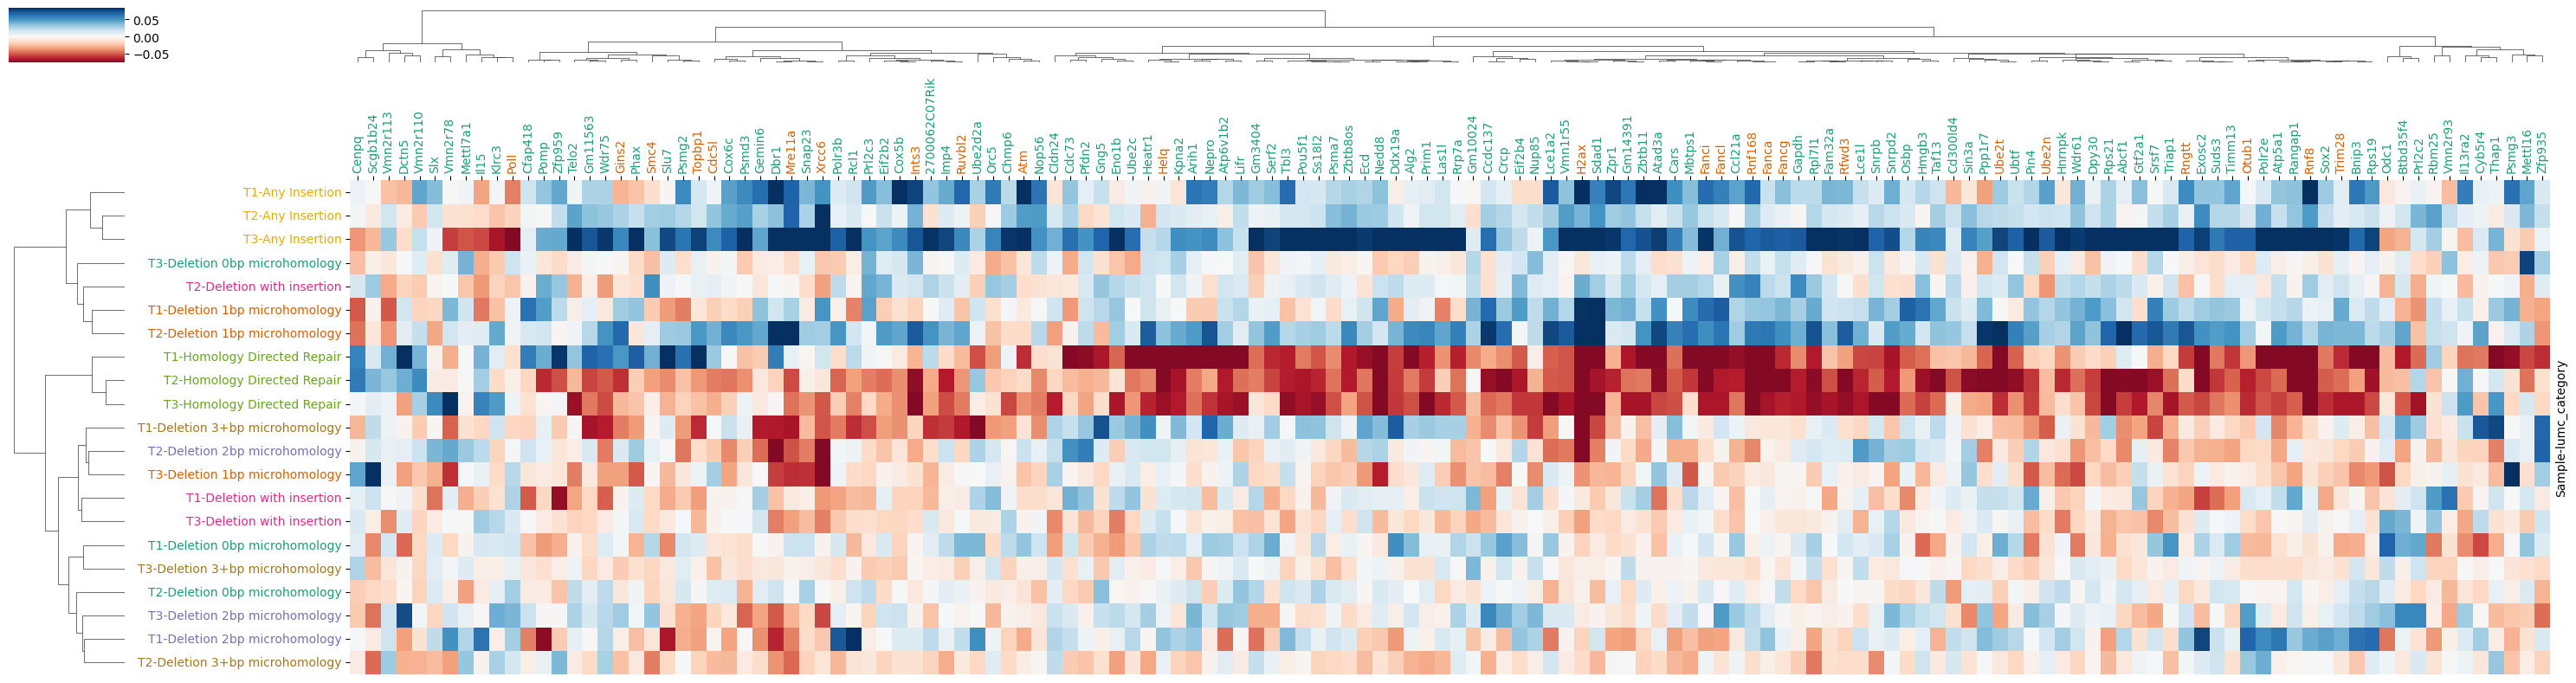

In [16]:
mutational_spectra_clustermap(X_imputed, outliers[:400], psuedo_controls, outlier_df=outlier_df, method="ward", metric="correlation", figsize=(30, 8))
plt.savefig(get_experiment_artifacts() + "mutationa_spectra_clustering_correlation_ward.pdf")


All: (35968, 7)
Outliers: (276, 7)
Psuedo controls: (200, 7)
Outliers, post pivot: (136, 14)
Mean psuedo control: (14,)
Log2 fold change: (136, 14)


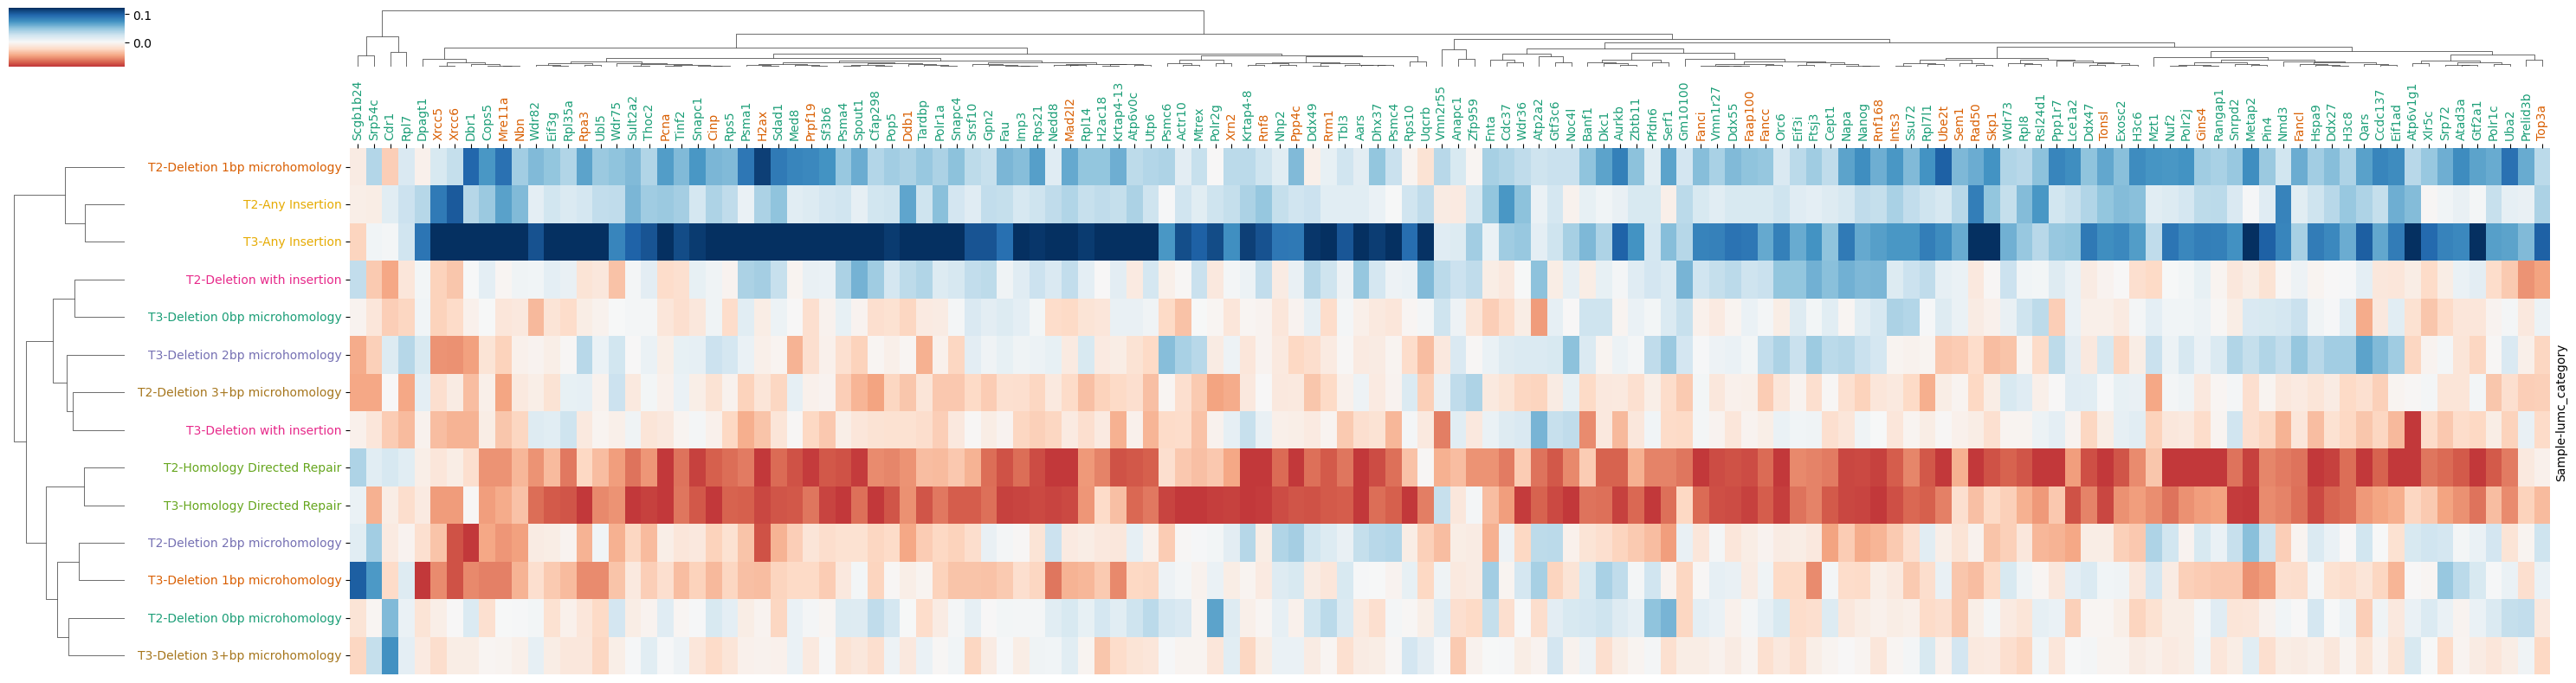

In [17]:
Xplot = {
    "T2": X_imputed["T2"],
    "T3": X_imputed["T3"]
}
mutational_spectra_clustermap(Xplot, outliers[:140], psuedo_controls, outlier_df=outlier_df, method="ward", metric="correlation", figsize=(30, 8))
plt.show()

All: (52400, 7)
Outliers: (330, 7)
Psuedo controls: (300, 7)
Outliers, post pivot: (30, 21)
Mean psuedo control: (21,)
Log2 fold change: (30, 21)


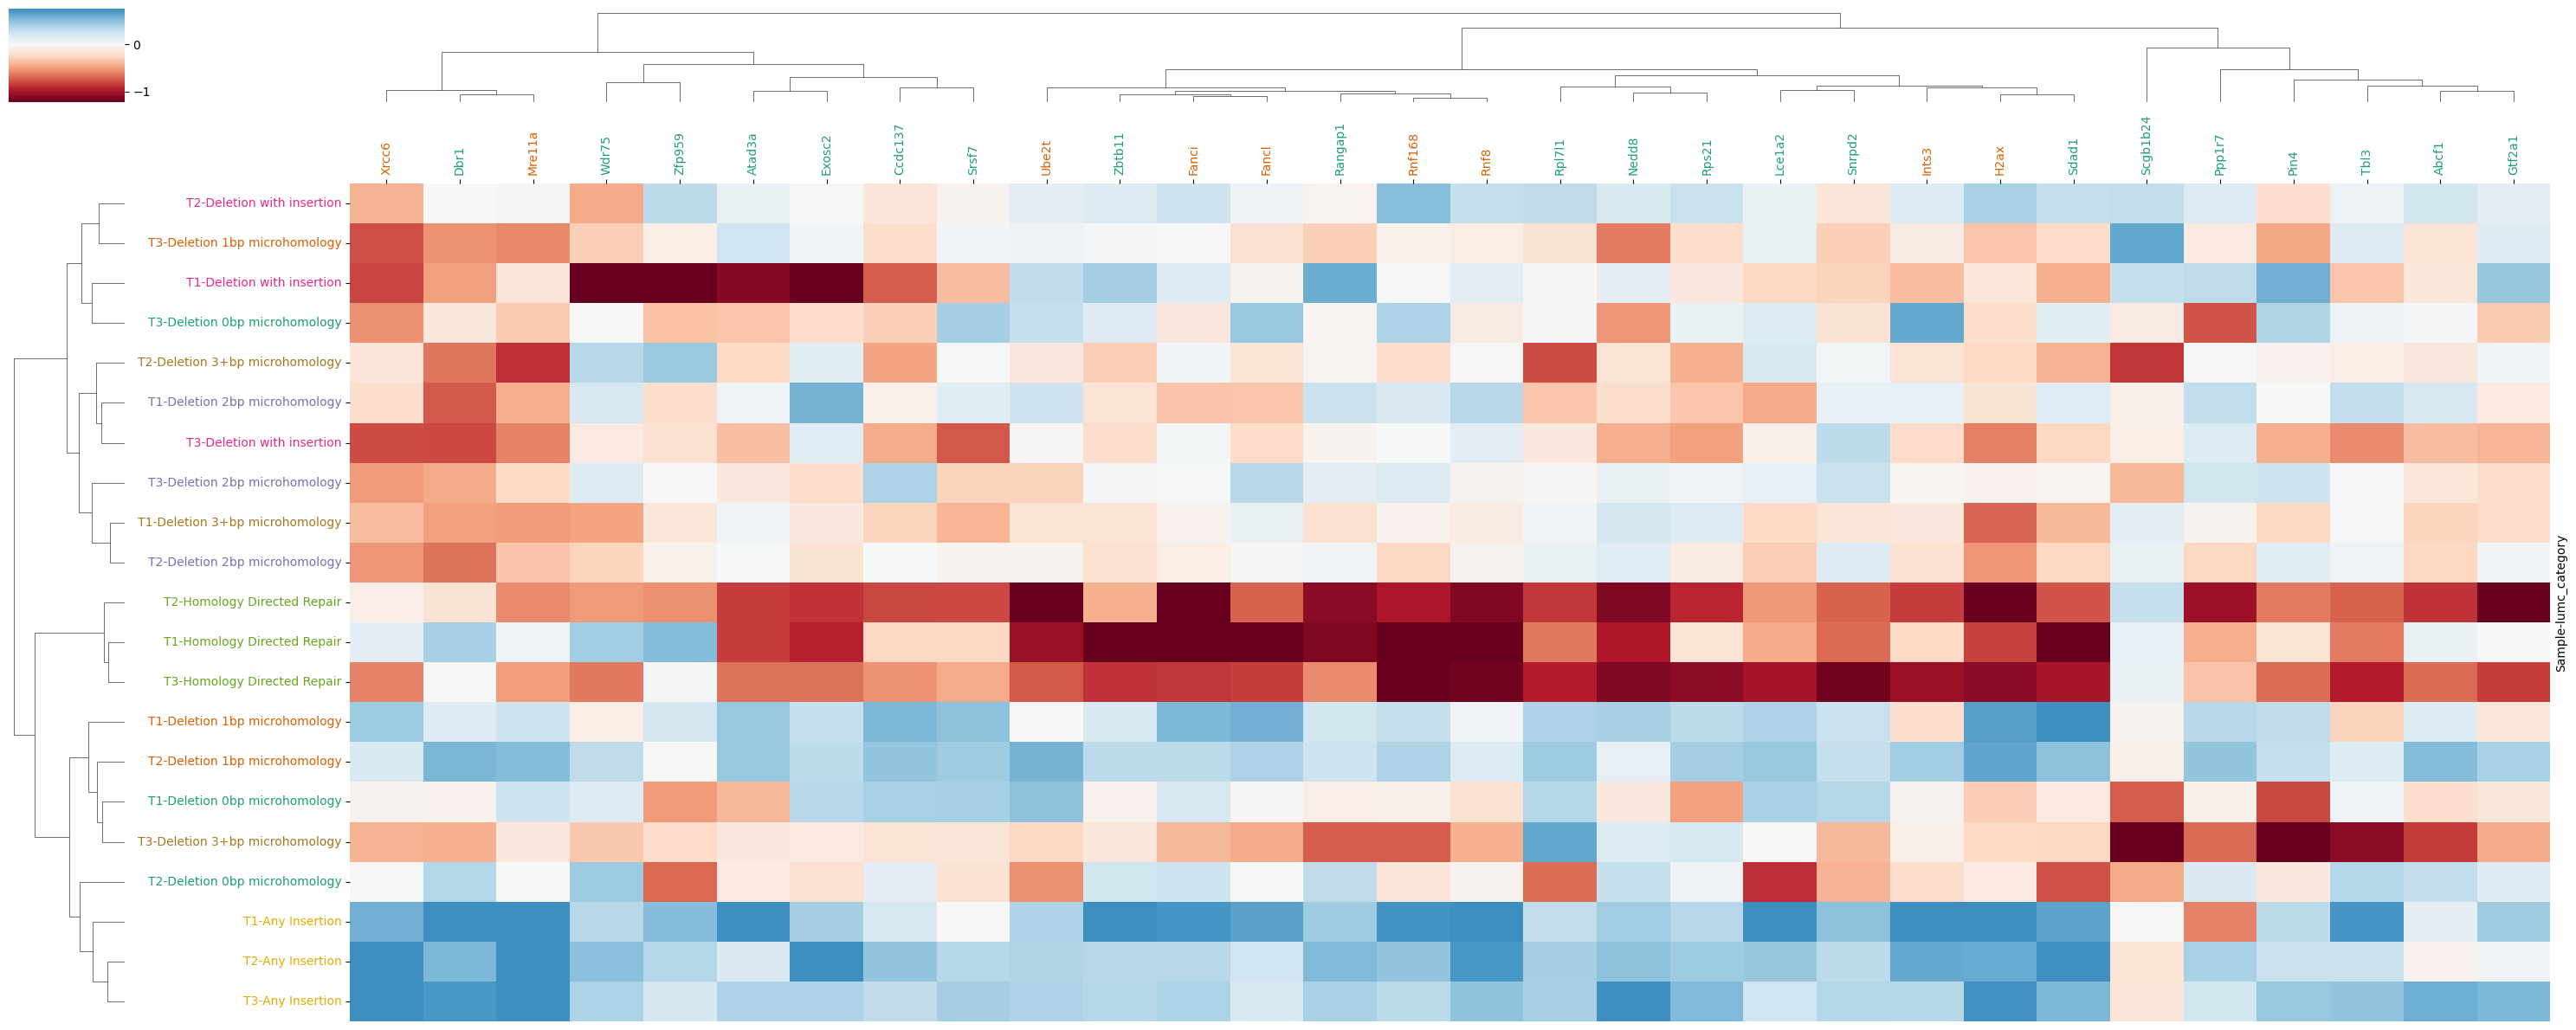

In [18]:
mutational_spectra_clustermap(X_imputed, outliers[:150], psuedo_controls, log_fold_change=True, outlier_df=outlier_df)
plt.show()

All: (52400, 7)
Outliers: (1349, 7)
Psuedo controls: (300, 7)
Outliers, post pivot: (249, 21)
Mean psuedo control: (21,)
Log2 fold change: (249, 21)


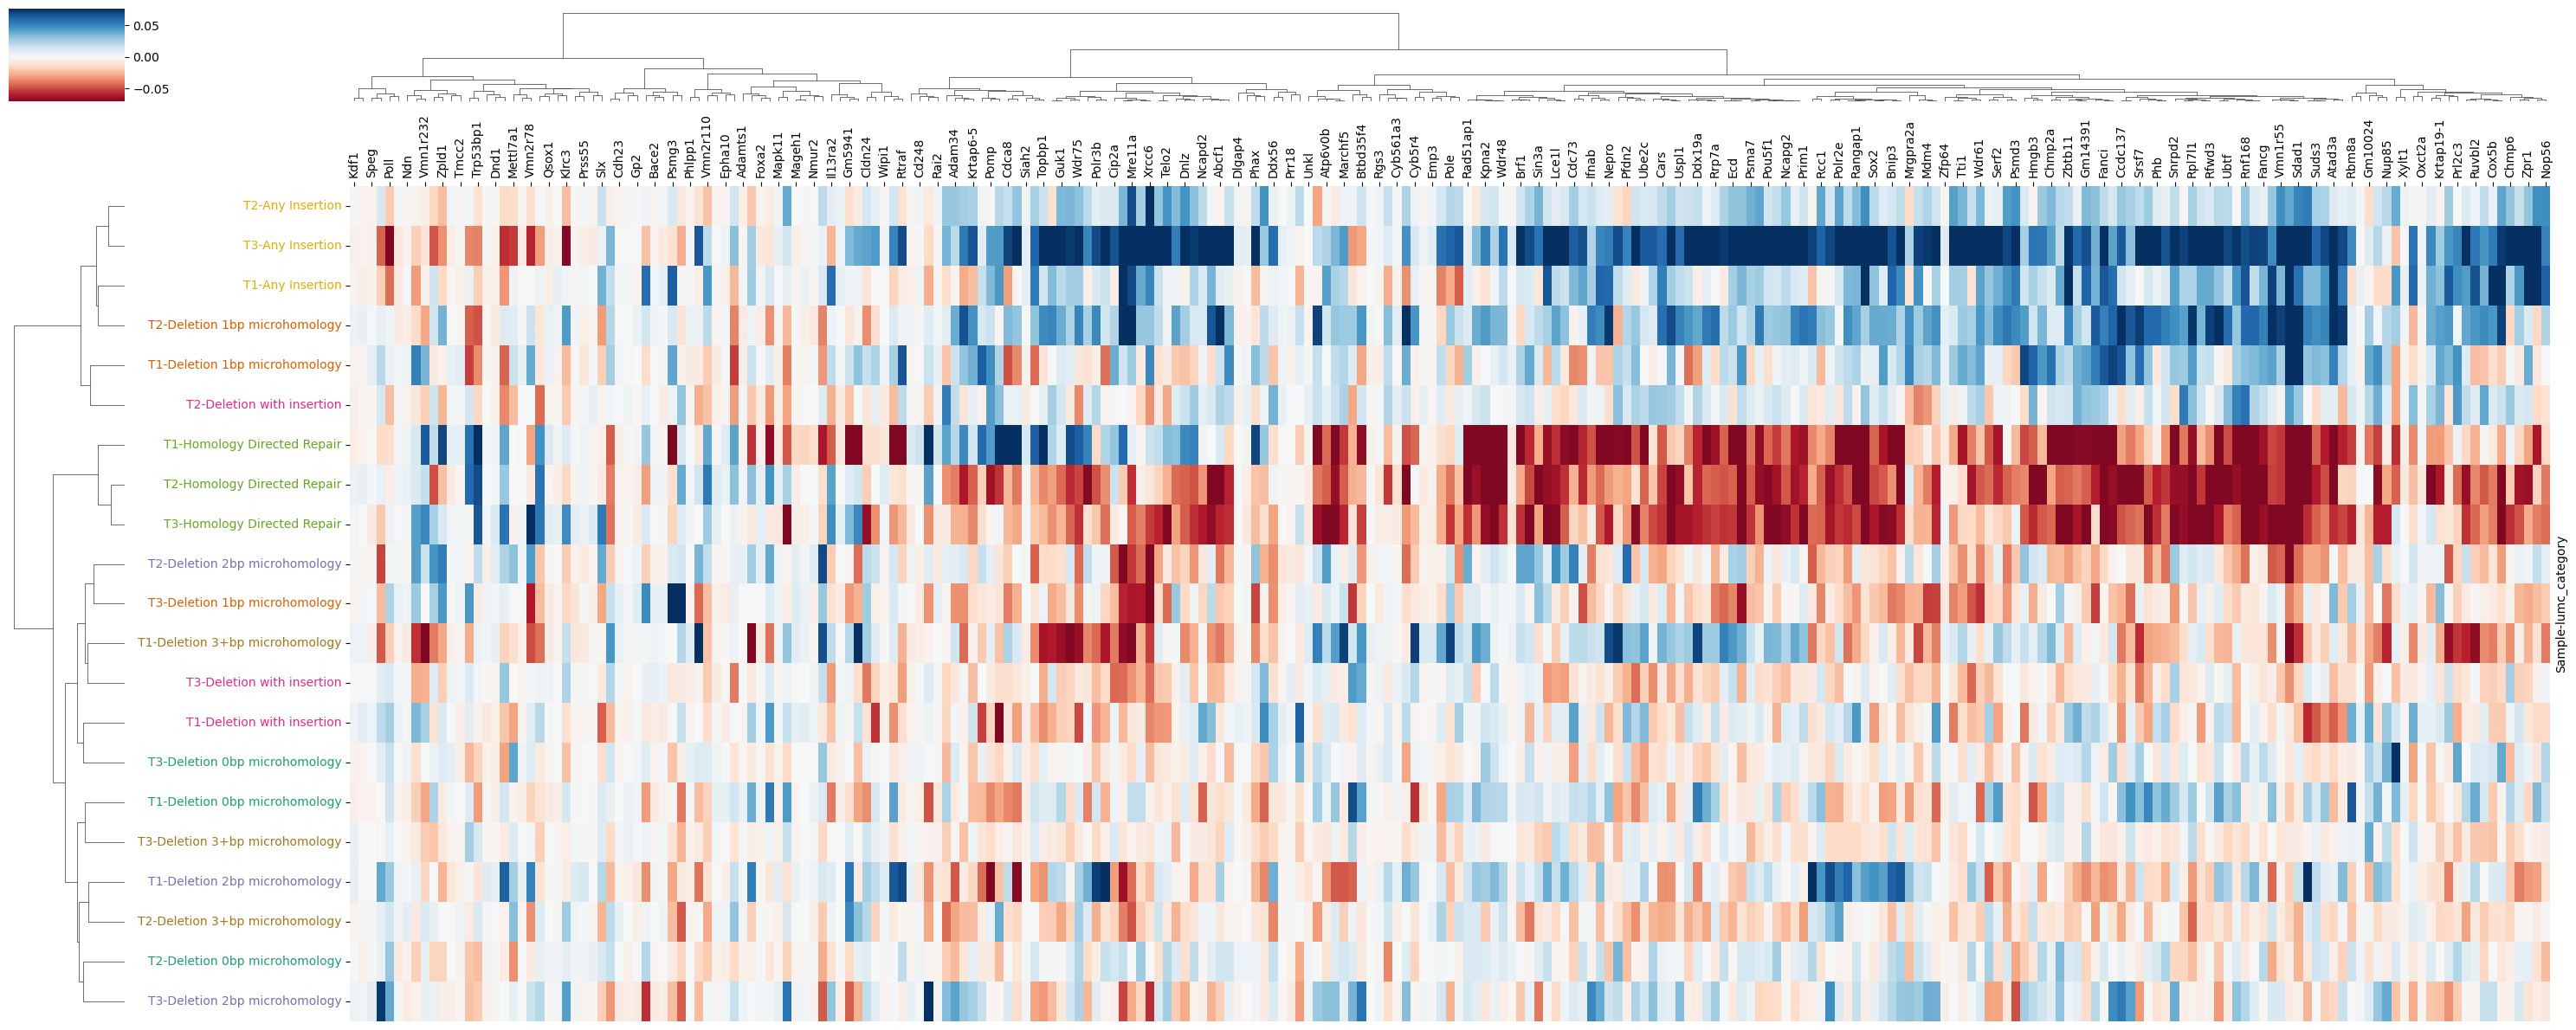

In [21]:
mutational_spectra_clustermap(X_imputed, outliers.to_list() + list(psuedo_controls[:50]), psuedo_controls, log_fold_change=False)
plt.show()

### Conclusion

We may be able to use simple clustering metheods to group genes with consistent behaviour together.

One issue however, is that so, genes do not have enough data in all samples.

We could relax the restriction. OR, we could try impute data. Imputing data may be dangerous. 

### Use aggregated target profiles to cluster genes based on their activity? 
Have less features, reduced curse of dimensionality
Don't need to throw away as much data

Maybe shared embedding space for all profiles? Use non-linear dim reduction like autoencoder with target site as a class attribute (or maybe not). Want to see if I can integrate the data from the different target sites. Concating the target sites is not efficient and can't use genes with missing target site data.

Could cluster each site seperately with cluster maps or PCA. Not sure if that's a benefit. 